In [1]:
import anndata as ad
import dask.distributed as dd
import h5py
import scanpy as sc

In [2]:
tissue = 'heart'
dask_chunk_size = 100_000
n_workers = 4
threads_per_worker = 4
dashboard_port = 8786

In [3]:
path = f'../../data/{tissue}.h5ad'

In [4]:
cluster = dd.LocalCluster(n_workers=n_workers, threads_per_worker=threads_per_worker, dashboard_address=f":{dashboard_port}")
client = dd.Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8786/status,
Dashboard: http://127.0.0.1:8786/status,Workers: 4
Total threads: 16,Total memory: 246.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42503,Workers: 4
Dashboard: http://127.0.0.1:8786/status,Total threads: 16
Started: Just now,Total memory: 246.55 GiB
Comm: tcp://127.0.0.1:43937,Total threads: 4
Dashboard: http://127.0.0.1:33885/status,Memory: 61.64 GiB
Nanny: tcp://127.0.0.1:36581,


In [5]:
f = h5py.File(path, "r")
f

<HDF5 file "heart.h5ad" (mode r)>

In [6]:
%%time
add = ad.AnnData(
    obs=ad.io.read_elem(f["obs"]),
    var=ad.io.read_elem(f["var"]),
)
add.X = ad.experimental.read_elem_as_dask(
    f["X"], chunks=(dask_chunk_size, add.shape[1])
)
add

CPU times: user 2.54 s, sys: 451 ms, total: 2.99 s
Wall time: 2.89 s


AnnData object with n_obs × n_vars = 1559974 × 60530
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [7]:
add.X

dask.array<make_dask_chunk, shape=(1559974, 60530), dtype=float32, chunksize=(100000, 60530), chunktype=scipy.csr_matrix>

In [8]:
%%time
add.layers["counts"] = add.X.copy()  # Making sure we keep access to the raw counts
sc.pp.normalize_total(add, target_sum=1e4)

CPU times: user 13.2 ms, sys: 7 μs, total: 13.2 ms
Wall time: 12.6 ms


In [9]:
%%time
sc.pp.log1p(add)

CPU times: user 2.14 ms, sys: 0 ns, total: 2.14 ms
Wall time: 2.15 ms


In [10]:
%%time
sc.pp.highly_variable_genes(add)

CPU times: user 3.04 s, sys: 378 ms, total: 3.42 s
Wall time: 34.9 s


In [11]:
%%time
sc.pp.pca(add)

CPU times: user 58.7 s, sys: 1.11 s, total: 59.8 s
Wall time: 55 s


In [12]:
%%time
add.obsm["X_pca"] = add.obsm["X_pca"].compute()

CPU times: user 7.27 s, sys: 777 ms, total: 8.05 s
Wall time: 30.4 s


In [13]:
t10 = add.obs.cell_type.value_counts().iloc[:10]
a10 = add[add.obs.cell_type.isin(t10.index)]
a10

View of AnnData object with n_obs × n_vars = 1203873 × 60530
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

/home/ubuntu/scanpy/src/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


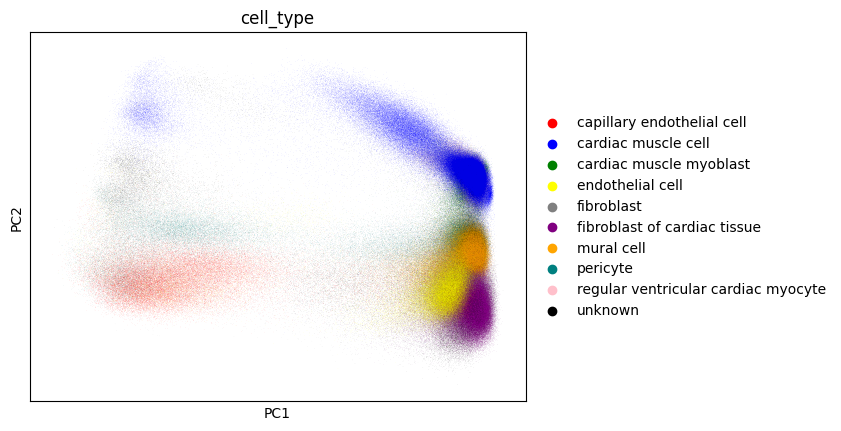

CPU times: user 6.05 s, sys: 366 ms, total: 6.41 s
Wall time: 6.29 s


In [14]:
%%time
sc.pl.pca(a10, color="cell_type", palette=["red", "blue", "green", "yellow", "grey", "purple", "orange", "teal", "pink", "black"])